*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
# try:
#   # %tensorflow_version only exists in Colab.
#   !pip install tf-nightly
# except Exception:
#   pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-12-10 16:34:50--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  1.98MB/s    in 0.2s    

2021-12-10 16:34:51 (1.98 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-12-10 16:34:51--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [ ]:
# Make Training dataset
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])

# Show first 5 entries of the Training dataset
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
# Make Testing dataset
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])

# Show first 5 entries of the Testing dataset
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
# Show column information of Training dataset
df_train.info()

# Show column information of Testing dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       4179 non-null   object
 1   x       4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       1392 non-null   object
 1   x       1392 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


In [ ]:
# Convert the 'y' column to category type and get categorical codes
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes

# Show first 5 rows
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0.5, 1.0, 'Number of ham and spam messages')

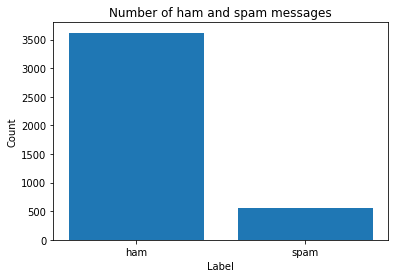

In [ ]:
# Get the count of 'ham' and 'spam' labels in the Training dataset
bar = df_train['y'].value_counts()

# Plot the counts in a bar graph
plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of ham and spam messages')

In [ ]:
# Import nltk (Natural Language ToolKit) for natural language processing
import nltk
# Download the 'stopwords' module
nltk.download('stopwords')
# Download the 'wordnet' module as Vocabulary for the Lemmatizer
nltk.download('wordnet')

# Import WordNet Lemmatizer
from nltk.stem import WordNetLemmatizer
# Import Stopwords module
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Import the re (Regular Expressions) module
import re

# Set the stopwords to 'english'
stopwords_eng = set(stopwords.words('english'))

# Initialize the Lemmatizer to WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Make a function to clean the text
def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [ ]:
# Clean the 'x' column with the previous function
X_train = df_train['x'].apply(lambda x: clean_txt(x))

# Show the first five elements
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

In [ ]:
# Import Tensorflow Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
# Import Sequence from Keras
from keras.preprocessing import sequence

# Keep the 1000 most frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

# Initialize the Tokenizer
tknizr = Tokenizer(num_words=max_words)
tknizr.fit_on_texts(X_train)

# Get the sequences
sequences = tknizr.texts_to_sequences(X_train)

# Show the first five sequences
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [ ]:
# Pad the sequences with zeros
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

# Show the first five sequences in the sequences matrix
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

In [ ]:
# Initialize the Input of the model
i = tf.keras.layers.Input(shape=[max_len])

# Initialize the Outputs of the model
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

# Initialize the model
model = tf.keras.models.Model(inputs=i, outputs=x)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable p

In [ ]:
# Train the model
trained_model = model.fit(
    sequences_matrix,
    y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #            min_delta=0.0001)],
)

Epoch 1/10
27/27 [==============================] - 9s 122ms/step - loss: 0.3856 - accuracy: 0.8750 - val_loss: 0.1439 - val_accuracy: 0.9498
Epoch 2/10
27/27 [==============================] - 2s 92ms/step - loss: 0.1369 - accuracy: 0.9545 - val_loss: 0.0952 - val_accuracy: 0.9833
Epoch 3/10
27/27 [==============================] - 2s 88ms/step - loss: 0.0640 - accuracy: 0.9868 - val_loss: 0.1176 - val_accuracy: 0.9833
Epoch 4/10
27/27 [==============================] - 2s 85ms/step - loss: 0.0531 - accuracy: 0.9904 - val_loss: 0.1416 - val_accuracy: 0.9833
Epoch 5/10
27/27 [==============================] - 2s 83ms/step - loss: 0.0542 - accuracy: 0.9943 - val_loss: 0.1215 - val_accuracy: 0.9904
Epoch 6/10
27/27 [==============================] - 2s 82ms/step - loss: 0.0495 - accuracy: 0.9934 - val_loss: 0.1177 - val_accuracy: 0.9892
Epoch 7/10
27/27 [==============================] - 2s 80ms/step - loss: 0.0447 - accuracy: 0.9967 - val_loss: 0.1172 - val_accuracy: 0.9904
Epoch 8/10
2

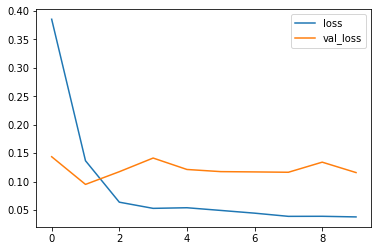

In [ ]:
plt.plot(trained_model.history['loss'], label='loss')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.legend()

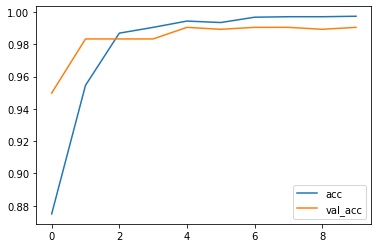

In [ ]:
plt.plot(trained_model.history['accuracy'], label='acc')
plt.plot(trained_model.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# Make a preprocessing function to clean the text
def preprocessing(X):
  # Apply the cleaning function on the input
  x = X.apply(lambda x: clean_txt(x))
  # Convert the output into sequences
  x = tknizr.texts_to_sequences(x)

  # Return the padded sequences
  return sequence.pad_sequences(x, maxlen=max_len)

In [ ]:
# Evaluate the model
evaluation = model.evaluate(preprocessing(df_test['x']), y_test)

print('Loss: {:.3f}, Accuracy: {:.3f}'.format(evaluation[0], evaluation[1]))

44/44 [==============================] - 1s 23ms/step - loss: 0.1211 - accuracy: 0.9820
Loss: 0.121, Accuracy: 0.982


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  # Return 'ham' if probability is less than 50%, else return 'spam'
  return (p[0], ("ham" if p < 0.5 else "spam"))

# The text to predict
pred_text = "how are you doing today?"

# The
prediction = predict_message(pred_text)
print(prediction)

(0.0, 'ham')


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
